# Project：  HLS实现DFT算法

> 该实验改编自《FPGA并行编程》第四章 离散傅里叶变换，使用Xilinx Vitis HLS生成的DFT IP进行dft算法的加速。



### 导入Overlay和allocate


In [1]:
from pynq import Overlay  
from pynq import allocate

### 加载Overlay

In [2]:
overlay = Overlay('./DFT.bit') 
dft=overlay.dft_0

### 分配内存供IP使用

In [3]:
sample_len = 1024
reInput_buffer = allocate(shape=(sample_len,), dtype='float32')  
imgInput_buffer = allocate(shape=(sample_len,), dtype='float32')
reOut_buffer = allocate(shape=(sample_len,), dtype='float32')
imgOut_buffer = allocate(shape=(sample_len,), dtype='float32')

### 生成输入数据

In [4]:
import numpy as np
real_In =np.array(np.arange(0,1024,1.0))  
image_In =np.zeros((1,1024))            #输入生成的是长度为1024的简单信号,用于测试DFT的计算
print("输入数据实部:",real_In)         #长度为1024、实部从0线性增长到1023、虚部为全0的复数信号
print("输入数据虚部:",image_In)  

输入数据实部: [0.000e+00 1.000e+00 2.000e+00 ... 1.021e+03 1.022e+03 1.023e+03]
输入数据虚部: [[0. 0. 0. ... 0. 0. 0.]]


复制输入数据到输入缓冲区

In [5]:
np.copyto(reInput_buffer, real_In)
np.copyto(imgInput_buffer,image_In) 

### 配置IP核


直接打印查看各寄存器的信息

In [6]:
dft.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0),
  real_sample_1 = Register(real_sample=write-only),
  real_sample_2 = Register(real_sample=write-only),
  imag_sample_1 = Register(imag_sample=write-only),
  imag_sample_2 = Register(imag_sample=write-only),
  real_op_1 = Register(real_op=write-only),
  real_op_2 = Register(real_op=write-only),
  imag_op_1 = Register(imag_op=write-only),
  imag_op_2 = Register(imag_op=write-only)
}

直接在Register Map中交互

In [7]:
dft.register_map.real_sample_1 = reInput_buffer.physical_address  
dft.register_map.imag_sample_1 = imgInput_buffer.physical_address 
dft.register_map.real_op_1 = reOut_buffer.physical_address
dft.register_map.imag_op_1 = imgOut_buffer.physical_address

### 启动IP核

In [8]:
import time
dft.register_map.CTRL.AP_START=1 
start_time = time.time()
while True:
    reg = dft.register_map.CTRL.AP_DONE
    if reg != 1:
        break
end_time = time.time()

### 打印结果

In [9]:
print("DFT IP核耗时:{}s".format(end_time - start_time))
print("实部输出前10个:",reOut_buffer[0:10])  
print("虚部输出前10个:",imgOut_buffer[0:10])


DFT IP核耗时:0.0009677410125732422s
实部输出前10个: [ 5.2377600e+05 -5.1200800e+02 -5.1199518e+02 -5.1197339e+02
 -5.1201434e+02 -5.1199597e+02 -5.1200342e+02 -5.1202087e+02
 -5.1199860e+02 -5.1200165e+02]
虚部输出前10个: [     0.    166885.69   83441.93   55627.137  41719.445  33374.586
  27811.188  23837.205  20856.566  18538.182]


### 与python numpy库的fft相比较

In [10]:
import numpy as np
from time import time

# 生成输入
N = 1024
real_in = np.arange(N)
imag_in = np.zeros(N)

# 使用np.fft.fft直接计算DFT
start = time()
out = np.fft.fft(real_in)
end = time()
np_time = end - start
print("Numpy FFT耗时:", np_time)
print("实部输出前10个:")        
print(out.real[0:10])

print("虚部输出前10个:")
print(out.imag[0:10])

Numpy FFT耗时: 0.001928091049194336
实部输出前10个:
[ 5.23776e+05 -5.12000e+02 -5.12000e+02 -5.12000e+02 -5.12000e+02
 -5.12000e+02 -5.12000e+02 -5.12000e+02 -5.12000e+02 -5.12000e+02]
虚部输出前10个:
[     0.         166885.53000842  83441.97960358  55627.11373064
  41719.41898575  33374.59268656  27811.2006043   23837.19949695
  20856.56774251  18538.18221677]


### 与python 直接按定义算法算相比较

In [19]:
import numpy as np
import time

N = 1024
real_in = np.arange(N)
imag_in = np.zeros(N)

real_out = np.zeros(N)
imag_out = np.zeros(N)

start = time.time()

for k in range(N):
    for n in range(N):
        real = real_in[n] 
        imag = imag_in[n]
        
        angle = 2 * np.pi * k * n / N
        
        real_out[k] += real * np.cos(angle) - imag * np.sin(angle)
        imag_out[k] += real * np.sin(angle) + imag * np.cos(angle)

end = time.time()
        
print("DFT定义计算耗时:", end - start)
print("实部输出前10个:") 
print(real_out[0:10])
print("虚部输出前10个:")
print(imag_out[0:10])

DFT定义计算耗时: 217.99121689796448
实部输出前10个:
[ 5.23776e+05 -5.12000e+02 -5.12000e+02 -5.12000e+02 -5.12000e+02
 -5.12000e+02 -5.12000e+02 -5.12000e+02 -5.12000e+02 -5.12000e+02]
虚部输出前10个:
[      0.         -166885.53000842  -83441.97960358  -55627.11373064
  -41719.41898575  -33374.59268656  -27811.2006043   -23837.19949695
  -20856.56774251  -18538.18221677]


### DFT IP 应用

创建一个用户友好的API，直接返回dft后的幅值，以绘制频谱图

In [11]:
from pynq import DefaultIP
class DftDriver(DefaultIP):
    def __init__ (self, description):
        super().__init__(description=description)
    bindto = ['xilinx.com:hls:dft:1.0']
    
    def dft1024(self, reInput_buffer, imgInput_buffer,  reOut_buffer, imgOut_buffer):
    
        dft.register_map.real_sample_1 = reInput_buffer.physical_address  
        dft.register_map.imag_sample_1 = imgInput_buffer.physical_address 
        dft.register_map.real_op_1 = reOut_buffer.physical_address
        dft.register_map.imag_op_1 = imgOut_buffer.physical_address
        dft.register_map.CTRL.AP_START=1 
        
        real_res = reOut_buffer
        imag_res = imgOut_buffer
        complex_res = real_res + 1j * imag_res
        dft_signal_amp = np.abs(complex_res)

        return dft_signal_amp
    
overlay = Overlay('./DFT.bit') 
dft=overlay.dft_0

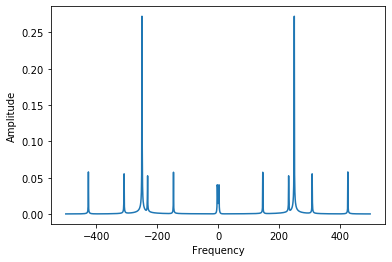

In [34]:
import numpy as np 
import matplotlib.pyplot as plt

# 参数设置
fs = 1000   # 采样频率 
N = 1024    # 信号长度
T = 1/1024
f_main = 250 # 主要频率成分 

# 生成时间轴
t = np.linspace(0, N/fs, N)  

# 生成多个正弦成分
f1 = np.random.randint(0, 100)  
f2 = np.random.randint(100, 200)
f3 = np.random.randint(200, 300) 
f4 = np.random.randint(300, 400)
f5 = np.random.randint(400, 500)

y1 = np.sin(2*np.pi*f1*t) 
y2 = np.sin(2*np.pi*f2*t)
y3 = np.sin(2*np.pi*f3*t)
y4 = np.sin(2*np.pi*f4*t)
y5 = np.sin(2*np.pi*f5*t)

# 主要频率成分
y_main = np.sin(2*np.pi*f_main*t)

# 混合信号
signal = y1 + y2 + y3 + y4 + y5 + 5*y_main  

# 归一化  
signal = signal / np.max(np.abs(signal))

np.copyto(reInput_buffer, signal)
np.copyto(imgInput_buffer,image_In)

# 计算DFT,直接返回幅值
dft_signal_amp = dft.dft1024(reInput_buffer, imgInput_buffer,  reOut_buffer, imgOut_buffer)


# 计算幅度谱
amplitude = dft_signal_amp / len(signal)

# 计算频率轴
freq = np.arange(-len(amplitude)/2,  len(amplitude)/2) * fs / len(amplitude)


# 绘图
plt.plot(freq, amplitude)  
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()

